In [65]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Lambda, LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import copy
from scipy.spatial.distance import cosine as cosine_distance
from keras.models import model_from_json
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [43]:
filename = input('filename: ')
json_file = open("model/"+filename+".json", "r")
loaded_model_json = json_file.read() 
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('model/weights_'+ filename + '.h5')

In [66]:
sequence_type = input('type(bfs? dfs?): ')
if sequence_type == 'bfs':
    dir = './latest_sequence/bfs/*'
else:
    dir = './latest_sequence/dfs/*'

# file read
all_data = []
sequence_length = []
graph_group = []
for file in sorted(glob.glob(dir)):
    graph_group.append(file.split('/')[-1].replace('.txt', ''))
    datasets = []
    for f in open(file, 'r'):
        (u, v, w) = f[1:-2].split(',')
        datasets.append([int(u), int(v), float(w)])
    sequence_length.append(len(datasets))
    all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

type(bfs? dfs?): bfs


In [67]:
x_train, x_test, train_name, test_name = train_test_split(all_data, graph_group, test_size=0.3)
x_test, x_val, test_name, val_name = train_test_split(x_test, test_name, test_size=0.33)

In [68]:
graph_length = len(glob.glob('./latest_graph_data/*'))
embedding = [[0 for i in range(64)] for i in range(graph_length)]

In [69]:
lstm_autoencoder = loaded_model

In [70]:
encoder = Model(lstm_autoencoder.input, lstm_autoencoder.layers[2].output)

In [76]:
def getIndexFromGraph(filename):
    index = int(filename.split('-')[0].replace('graph', ''))
    return index

In [71]:
num_dict = { i:0 for i in range(graph_length)}

for index, data in enumerate(all_data):
    data = data.reshape(1, data.shape[0], data.shape[1])
    encoded = encoder.predict(data)
    loc = getIndexFromGraph(graph_group[index])
    num_dict[loc] += 1
    embedding[loc] += encoded.reshape(encoded.shape[1])    

In [73]:
def calculateGraphGroup(num_dict):
    for index, data in enumerate(all_data):
        loc = getIndexFromGraph(graph_group[index])
        num_dict[loc] += 1
    return num_dict

In [101]:
def getEmbeddingSum():
    sum_embedding = [[0 for i in range(64)] for i in range(graph_length)]
    for index, data in enumerate(all_data):
        data = data.reshape(1, data.shape[0], data.shape[1])
        embedded = encoder.predict(data)
        loc = getIndexFromGraph(graph_group[index])
        sum_embedding[loc] += embedded.reshape(embedded.shape[1])
    return sum_embedding

In [109]:
def getEmbeddingAvg():
    avg_embedding = [[0 for i in range(64)] for i in range(graph_length)]
    sum_embedding = getEmbeddingSum()
    for index in range(graph_length):
        avg_embedding[index] = sum_embedding[index] / num_dict[index]
    return avg_embedding

In [144]:
def getEmbeddingVector(index):
    data_index = []
    data = []
    counts = num_dict[index]
    for num, i in enumerate(graph_group):
        if index == getIndexFromGraph(i):
            data_index.append(num)
        if len(data_index) == counts:
            break
    for i in data_index:
        data.append(all_data[i])
    return data

In [146]:
def getEmbeddingMode(): # 최빈값
    mode_embedding = [[0 for i in range(64)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = getEmbeddingVector(index)
        print(vectors)
        # 여기부터 수정
    return mode_embedding

In [133]:
num_dict = { i:0 for i in range(graph_length)}
num_dict = calculateGraphGroup(num_dict)

In [147]:
sum_embedding = getEmbeddingSum()
avg_embedding = getEmbeddingAvg()

In [13]:
avg_embedding = [[0 for i in range(64)] for i in range(525)]

for index, embed in enumerate(embedding):
    avg_embedding[index] = (embedding[index] / num_dict[index])

In [96]:
import import_ipynb
import drawingGraph as G

In [82]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum(a-b) ** 2)

In [79]:
obj_name = 'graph' + str(0)

In [80]:
obj = sum_embedding[0]

In [84]:
def getGraphOrder(dist):
    ordered = copy.deepcopy(dist)
    ordered.sort()
    
    names = []
    
    for item in ordered:
        for index, d in enumerate(dist):
            if item == d:
                names.append(index+1)
                break
    return names, ordered

In [85]:
dist_euc = []

for embed in sum_embedding[1:]:
    dist_euc.append(euclidean_distance(obj, embed))
names_euc, ordered_euc = getGraphOrder(dist_euc)

In [86]:
dist_cos = []
for embed in sum_embedding[1:]:
    dist_cos.append(cosine_distance(obj, embed))
names_cos, ordered_cos = getGraphOrder(dist_cos)

In [87]:
datasets = [[] for i in range(525)]
for n, data in zip(graph_group, all_data):
    index = int(n.split('-')[0].replace('graph', ''))
    if len(datasets[index]) == 0:
        d = []
        for row in data:
            u, v, w = row
            d.append([int(u), int(v), float(w)])
        datasets[index] = d

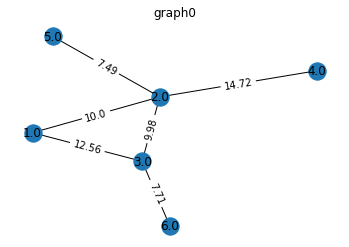

In [93]:
G.drawGraph('', obj_name, 1, data, False)

In [98]:
def getTop5Data(datasets, names):
    data = []
    for n in names:
        data.append(datasets[n])
    return data

In [99]:
top5_cos = getTop5Data(datasets, names_cos[:5])
back5_cos = getTop5Data(datasets, names_cos[-5:][::-1])

In [25]:
top5_euc = getTop5Data(datasets, names_euc[:5])
back5_euc = getTop5Data(datasets, names_euc[-5:][::-1])

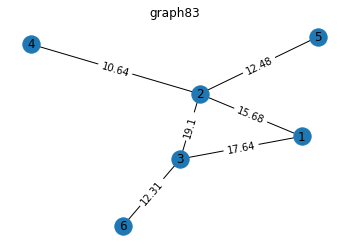

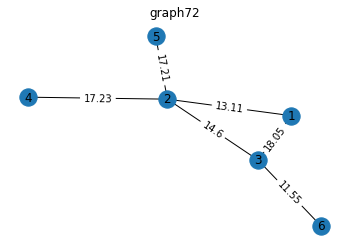

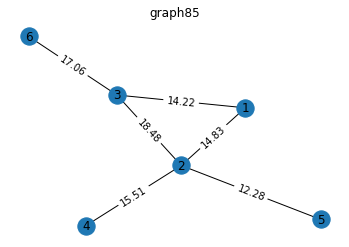

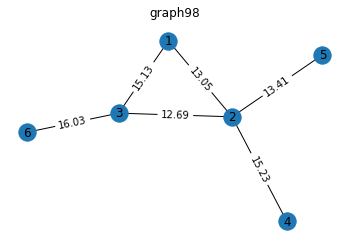

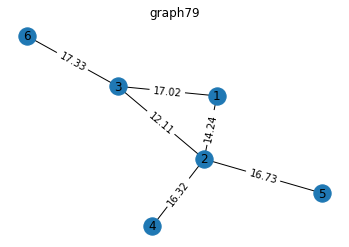

In [100]:
for index, data in enumerate(top5_cos):
    G.drawGraph('', 'graph' + str(names_cos[index]), index, data, False)

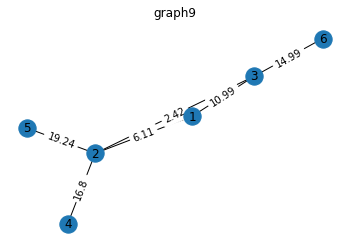

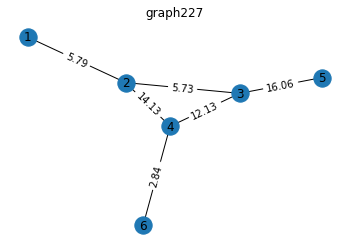

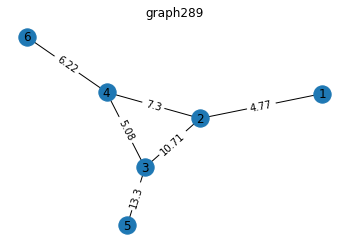

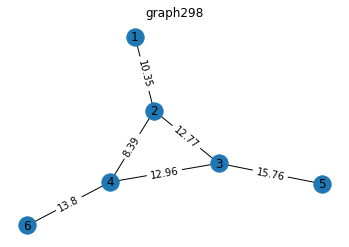

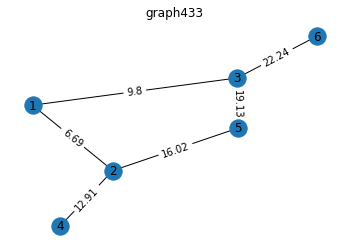

In [27]:
for index, data in enumerate(top5_euc):
    G.drawGraph('', 'graph' + str(names_euc[index]), index, data, False)

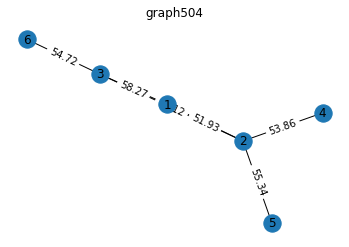

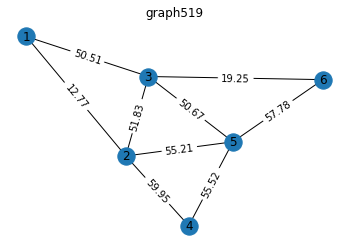

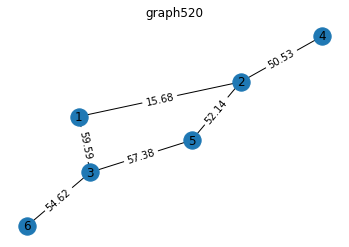

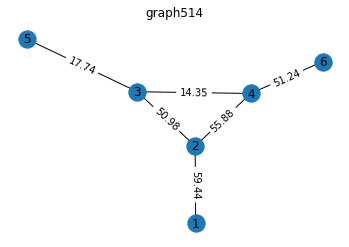

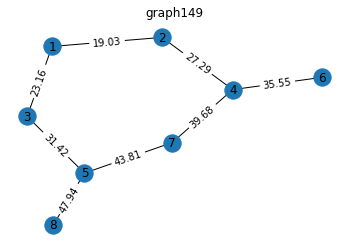

In [29]:
for index, data in enumerate(back5_euc):
    #print(data)
    G.drawGraph('', 'graph' + str(names_euc[len(names_euc)-index-1]), index, data, False)

#G.drawGraph('', obj_name, 1, data1, False)

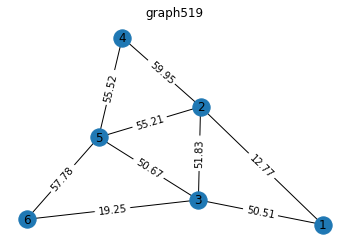

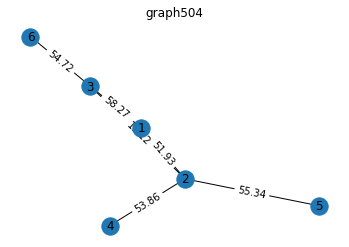

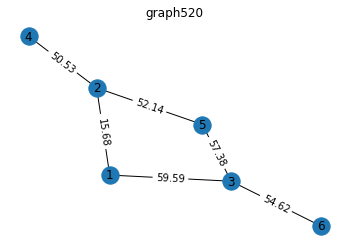

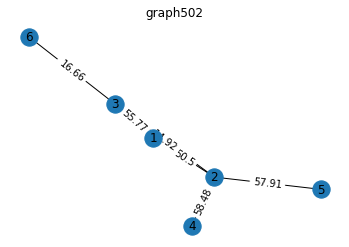

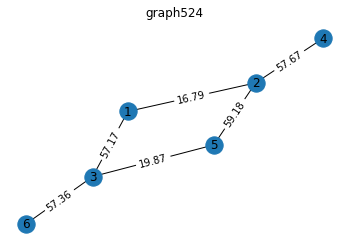

In [30]:
for index, data in enumerate(back5_cos):
    G.drawGraph('', 'graph' + str(names_cos[len(names_cos)-index-1]), index, data, False)

In [112]:
avg_obj = avg_embedding[0]
avg_obj_name = 'graph' + str(0)

In [113]:
dist_euc_a = []
for embed in avg_embedding[1:]:
    dist_euc_a.append(euclidean_distance(avg_obj, embed))
names_euc_a, ordered_euc_a = getGraphOrder(dist_euc_a)

In [114]:
dist_cos_a = []

for embed in avg_embedding[1:]:
    dist_cos_a.append(cosine_distance(avg_obj, embed))
names_cos_a, ordered_cos_a = getGraphOrder(dist_cos_a)

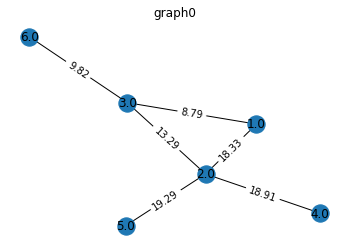

In [115]:
G.drawGraph('', avg_obj_name, 1, all_data[0], 0)

In [116]:
top5_cos_a = getTop5Data(datasets, names_cos_a[:5])
back5_cos_a = getTop5Data(datasets, names_cos_a[-5:][::-1])

In [117]:
top5_euc_a = getTop5Data(datasets, names_euc_a[:5])
back5_euc_a = getTop5Data(datasets, names_euc_a[-5:][::-1])

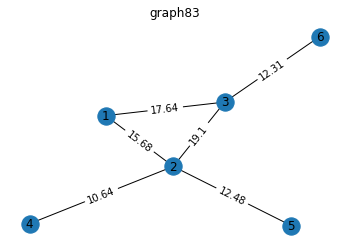

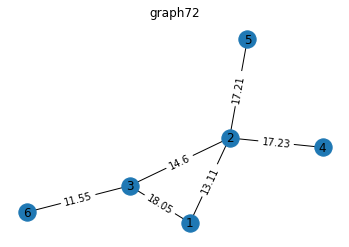

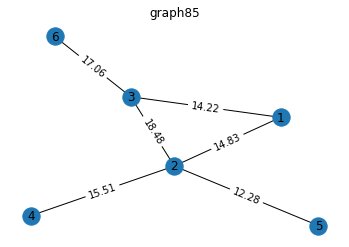

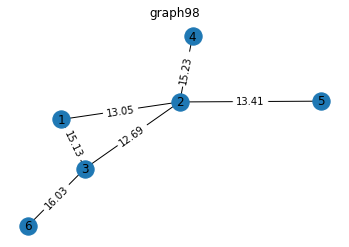

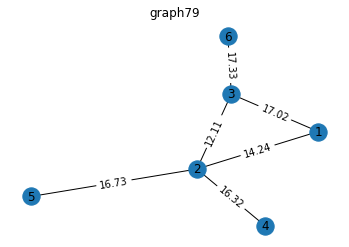

In [118]:
for index, data in enumerate(top5_cos_a):
    G.drawGraph('', 'graph'+str(names_cos_a[index]), index, data, 0)

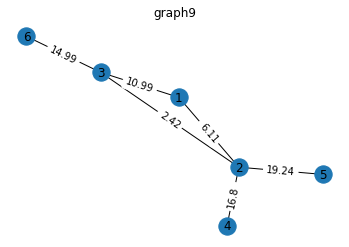

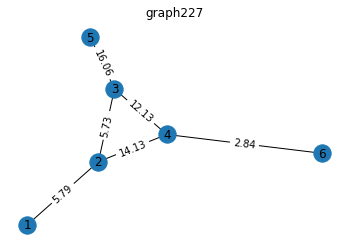

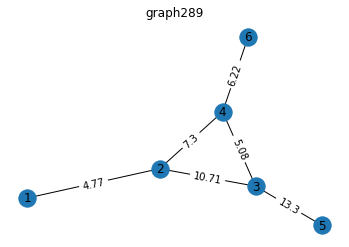

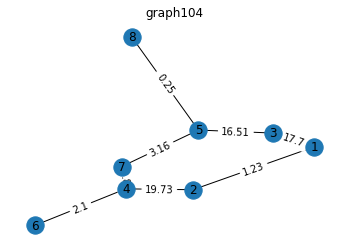

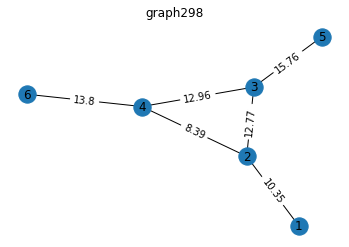

In [38]:
for index, data in enumerate(top5_euc_a):
    G.drawGraph('', 'graph'+str(names_euc_a[index]), index, data, 0)

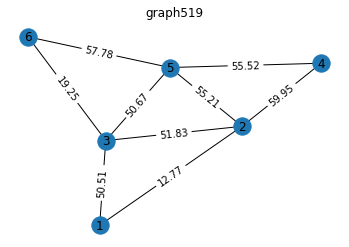

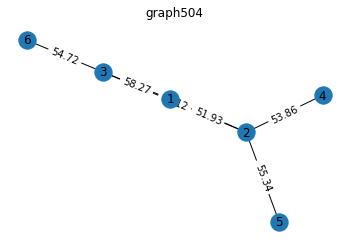

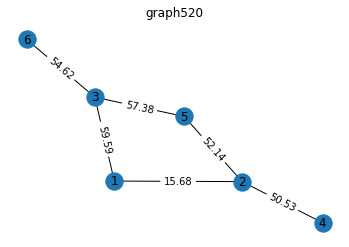

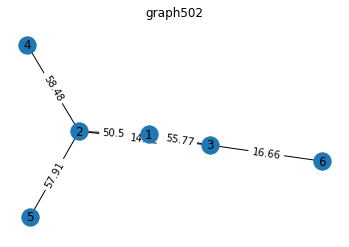

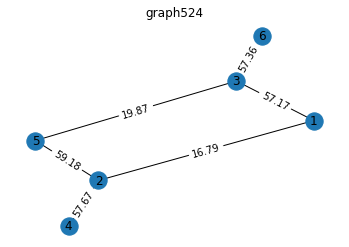

In [40]:
for index, data in enumerate(back5_cos_a):
    G.drawGraph('', 'graph'+str(names_cos_a[len(names_cos_a) - index -1]), index, data, 0)

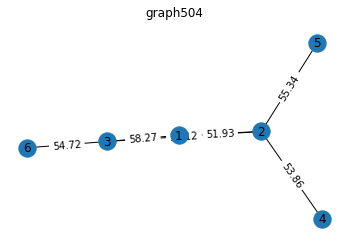

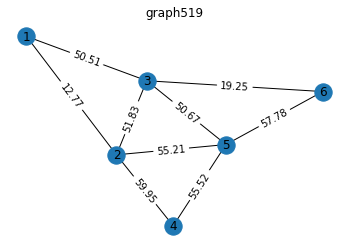

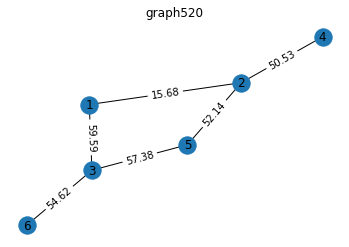

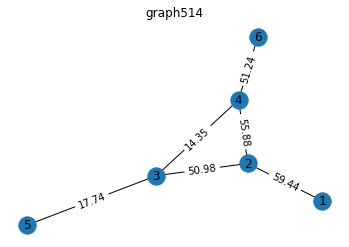

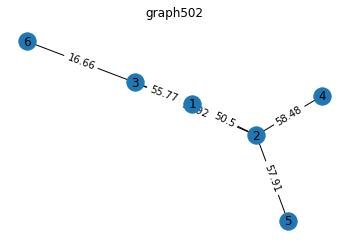

In [41]:
for index, data in enumerate(back5_euc_a):
    G.drawGraph('', 'graph'+str(names_euc_a[len(names_euc_a) - index -1]), index, data, 0)